In [2]:
from datasets import load_dataset

from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import json

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ---------- Preprocesing Functions ----------
def preprocess_paradetox_multilingual(example):
    return {
        "input_text": "detoxify: " + example["toxic_sentence"],
        "target_text": example["neutral_sentence"]
    }

def preprocess_paradetox(example):
    return {
        "input_text": "detoxify: " + example["en_toxic_comment"],
        "target_text": example["en_neutral_comment"]
    }

def clean_columns(dataset):
    return dataset.remove_columns(
        [col for col in dataset.column_names if col not in ["input_text", "target_text"]]
    )


def load_json_results(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        return json.load(f)


def save_variables_to_json(filename, **variables):
    """
    Saves given variables to a JSON file with their variable names as keys.

    Parameters:
    - filename (str): The name of the JSON file to write to.
    - **variables: Arbitrary keyword arguments representing variable names and their values.
    """
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(variables, f, ensure_ascii=False, indent=2)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [3]:
# ---------- Load and Process Datasets ----------
test_data_en = load_dataset("textdetox/multilingual_paradetox", split="en")
test_data_de = load_dataset("textdetox/multilingual_paradetox", split="de")
train_data = load_dataset("s-nlp/paradetox", split="train") 

In [4]:
import re

formatted_train = clean_columns(train_data.map(preprocess_paradetox))
formatted_en = clean_columns(test_data_en.map(preprocess_paradetox_multilingual))
formatted_de = clean_columns(test_data_de.map(preprocess_paradetox_multilingual))


def remove_emojis(text):
    # This regex pattern matches a wide range of emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags
        "\U00002700-\U000027BF"  # Dingbats
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def clean_emoji_batch(batch):
    batch["input_text"] = remove_emojis(batch["input_text"])
    batch["target_text"] = remove_emojis(batch["target_text"])
    return batch

formatted_train = formatted_train.map(clean_emoji_batch)
formatted_en = formatted_en.map(clean_emoji_batch)
formatted_de = formatted_de.map(clean_emoji_batch)


In [5]:
print("Test dataset en size:", len(formatted_en))
print("Test dataset de size:", len(formatted_de))
print("Train dataset size:", len(formatted_train))

print("Test en dataset columns:", formatted_en.column_names)
print("Test de dataset columns:", formatted_de.column_names)
print("Train dataset columns:", formatted_train.column_names)

Test dataset en size: 400
Test dataset de size: 400
Train dataset size: 19744
Test en dataset columns: ['input_text', 'target_text']
Test de dataset columns: ['input_text', 'target_text']
Train dataset columns: ['input_text', 'target_text']


In [6]:
save_variables_to_json(
    "formatted_de.json",
    input_texts=formatted_de["input_text"],
    reference_texts=formatted_de["target_text"],
)

save_variables_to_json(
    "formatted_en.json",
    input_texts=formatted_en["input_text"],
    reference_texts=formatted_en["target_text"],
)

save_variables_to_json(
    "formatted_train.json",
    input_texts=formatted_train["input_text"],
    reference_texts=formatted_train["target_text"],
)

In [24]:
def tokenize(examples):
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=128,
        padding="max_length",
        truncation=True
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["target_text"],
            max_length=128,
            padding="max_length",
            truncation=True
        )
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label_seq]
        for label_seq in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply to both datasets
tokenized_train = formatted_train.map(tokenize, batched=True)
tokenized_eval = formatted_en.map(tokenize, batched=True)

train_dataset = tokenized_train
eval_dataset = tokenized_eval

Map:   0%|          | 0/19744 [00:00<?, ? examples/s]

c:\Users\jonaz\git\Maria_stuff\Maria_code\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [25]:
print("Train dataset size:", len(train_dataset))
print("Eval dataset size:", len(eval_dataset))

Train dataset size: 19744
Eval dataset size: 400


In [ ]:
from transformers import (
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
import torch
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-detox-en-base",
    overwrite_output_dir=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=3e-5,
    num_train_epochs=3,
    fp16=torch.cuda.is_available(),
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs_en_base",
    report_to="none"
)

# Standard Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Start training
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.208900,1.146010
2,1.109400,1.105784
3,1.102200,1.101930


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=3702, training_loss=1.1768440337904977, metrics={'train_runtime': 470.8552, 'train_samples_per_second': 125.797, 'train_steps_per_second': 7.862, 'total_flos': 2004141396197376.0, 'train_loss': 1.1768440337904977, 'epoch': 3.0})

In [1]:
import matplotlib.pyplot as plt
import json

# Save logs to JSON
with open("trainer_log.json", "w", encoding="utf-8") as f:
    json.dump(trainer.state.log_history, f, indent=2)

# ✅ Now read logs back from file
with open("trainer_log.json", "r", encoding="utf-8") as f:
    logs = json.load(f)

# Extract and plot penalty scores
penalties = [log["penalty_score"] for log in logs if "penalty_score" in log]
plt.plot(penalties)
plt.xlabel("Training step")
plt.ylabel("Penalty Score")
plt.title("Toxicity Penalty Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'trainer' is not defined

In [34]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Path to your saved model
checkpoint_path = "mt5-detox-en-base/checkpoint-3702"

# Load model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(checkpoint_path)
model = T5ForConditionalGeneration.from_pretrained(checkpoint_path)

# Send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

## English Translation

In [11]:
""" from transformers import MarianMTModel, MarianTokenizer

# Load model and tokenizer
model_name = "Helsinki-NLP/opus-mt-de-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

def translate_de_to_en(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    translated = model.generate(**inputs)
    return [tokenizer.decode(t, skip_special_tokens=True) for t in translated]

translate_de_to_en = translate_de_to_en(formatted_de["input_text"]) """

' from transformers import MarianMTModel, MarianTokenizer\n\n# Load model and tokenizer\nmodel_name = "Helsinki-NLP/opus-mt-de-en"\ntokenizer = MarianTokenizer.from_pretrained(model_name)\nmodel = MarianMTModel.from_pretrained(model_name)\n\ndef translate_de_to_en(texts):\n    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)\n    translated = model.generate(**inputs)\n    return [tokenizer.decode(t, skip_special_tokens=True) for t in translated]\n\ntranslate_de_to_en = translate_de_to_en(formatted_de["input_text"]) '

In [36]:
input_text = "You are fucking ugly"
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

# Generate detoxified output
output = model.generate(
    **inputs,
    max_length=50,
    num_beams=4,                      # optional: beam search improves fluency
    early_stopping=True,              # stop generation when EOS is reached
    decoder_start_token_id=tokenizer.pad_token_id  # force decoder to start properly
)

# Decode the generated output
decoded = tokenizer.decode(output[0])
print("Detoxified:", decoded)

def generate_detoxified(text):
    input_text = "detoxify (en): " + text
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True).to(model.device)
    output_ids = model.generate(input_ids, max_length=128)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(generate_detoxified("You are the worst piece of garbage."))
print(generate_detoxified("Nobody likes you, idiot."))

Detoxified: <pad> You are ugly</s>
You are the worst piece of garbage.
Nobody likes you.


In [37]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# ✅ Make sure you use the raw (non-tokenized) dataset
# If you accidentally removed input_text/target_text earlier, re-load or cache it

# 🔧 Batch size for faster inference (tune based on your GPU)
BATCH_SIZE = 16

# Collate function for batching text
def collate_fn(batch):
    texts = [ex["input_text"] for ex in batch]
    return tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

# DataLoader
loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Storage for results
detoxified_outputs = []
input_texts = []
reference_texts = []

# Run generation
model.eval()
for i, batch in enumerate(tqdm(loader)):
    batch = {k: v.to(model.device) for k, v in batch.items()}
    outputs = model.generate(
        **batch,
        max_length=50,
        num_beams=4,
        early_stopping=True,
        decoder_start_token_id=tokenizer.pad_token_id
    )
    
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    detoxified_outputs.extend(decoded)

    # Save corresponding original and reference text
    for j in range(len(decoded)):
        example = eval_dataset[i * BATCH_SIZE + j]
        input_texts.append(example["input_text"])
        reference_texts.append(example["target_text"])


100%|██████████| 25/25 [00:07<00:00,  3.38it/s]


In [30]:
import json

# Save results to a JSON file
output_data = {
    "input_texts": input_texts,
    "reference_texts": reference_texts,
    "detoxified_outputs": detoxified_outputs
}

with open("detoxified_results_base.json", "w", encoding="utf-8") as f:
    json.dump(output_data, f, ensure_ascii=False, indent=2)

print("Detoxified texts saved to detoxified_results_baseline.json ✅")

Detoxified texts saved to detoxified_results_baseline.json ✅


## BLEU Evaluation Score

In [39]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
#nltk.download("punkt_tab")
import numpy as np


smooth_fn = SmoothingFunction().method4

bleu_scores = []

for hyp, ref in zip(detoxified_outputs, reference_texts):
    hyp_tokens = nltk.word_tokenize(hyp)
    ref_tokens = nltk.word_tokenize(ref)
    
    score = sentence_bleu(
        [ref_tokens],
        hyp_tokens,
        smoothing_function=smooth_fn
    )
    bleu_scores.append(score)

avg_bleu = np.mean(bleu_scores)
print(f"Average BLEU Score: {avg_bleu:.4f}")


Average BLEU Score: 0.4890


## Bert-score

In [40]:
from bert_score import score

# Use your lists from earlier
# detoxified_outputs = [...]   # model-generated sentences
# reference_texts = [...]      # ground truth neutral sentences

P, R, F1 = score(detoxified_outputs, reference_texts, lang="en", verbose=True)

# Average scores
print(f"Average BERTScore Precision:  {P.mean():.4f}")
print(f"Average BERTScore Recall:     {R.mean():.4f}")
print(f"Average BERTScore F1:         {F1.mean():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 0.97 seconds, 413.45 sentences/sec
Average BERTScore Precision:  0.9489
Average BERTScore Recall:     0.9491
Average BERTScore F1:         0.9488


## Toxicity Score Evaluation

Original:    detoxify: then all of a sudden i see her , shes now got the big phony tits and everything .
Detoxified:  then all of a sudden i see her, shes now got the big tits and everything.
Toxicity Before: 0.93
Toxicity After:  0.93
--------------------------------------------------
Original:    detoxify: My page should be protected first so that worthless scum like you can't keep vandalizing it.
Detoxified:  My page should be protected first so that worthless stuff like you can't keep vandalizing it.
Toxicity Before: 0.95
Toxicity After:  0.55
--------------------------------------------------
Original:    detoxify: You made a mistake you ass.
Detoxified:  You made a mistake.
Toxicity Before: 0.97
Toxicity After:  0.00
--------------------------------------------------
Average Toxicity Before: 0.92
Average Toxicity After: 0.28


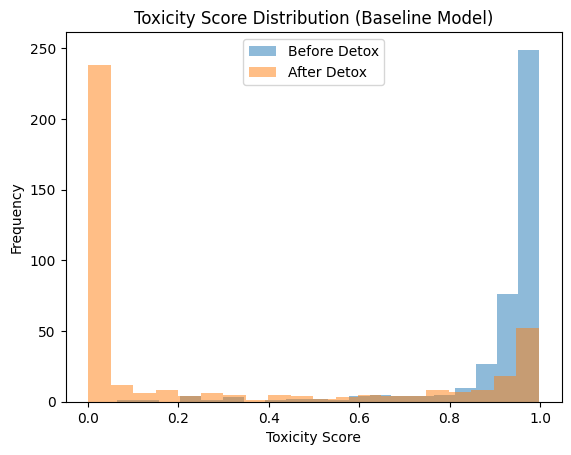

In [41]:
from detoxify import Detoxify

# Load Detoxify model
toxicity_model = Detoxify('unbiased')

# Run toxicity prediction
toxicity_scores = toxicity_model.predict(input_texts)
detoxified_scores = toxicity_model.predict(detoxified_outputs)

# Print sample comparisons
for i in range(3):
    print(f"Original:    {input_texts[i]}")
    print(f"Detoxified:  {detoxified_outputs[i]}")
    print(f"Toxicity Before: {toxicity_scores['toxicity'][i]:.2f}")
    print(f"Toxicity After:  {detoxified_scores['toxicity'][i]:.2f}")
    print("-" * 50)


import numpy as np
import matplotlib.pyplot as plt

# Calculate average toxicity
avg_toxicity_before = np.mean(toxicity_scores['toxicity'])
avg_toxicity_after = np.mean(detoxified_scores['toxicity'])

print(f"Average Toxicity Before: {avg_toxicity_before:.2f}")
print(f"Average Toxicity After: {avg_toxicity_after:.2f}")

# Plotting the distributions
plt.hist(toxicity_scores['toxicity'], bins=20, alpha=0.5, label='Before Detox')
plt.hist(detoxified_scores['toxicity'], bins=20, alpha=0.5, label='After Detox')
plt.xlabel('Toxicity Score')
plt.ylabel('Frequency')
plt.title('Toxicity Score Distribution (Baseline Model)')
plt.legend()
plt.show()


In [18]:
from scipy.stats import ttest_rel

# Example: compare two arrays of toxicity scores
before = np.array(toxicity_scores['toxicity'])
after = np.array(detoxified_scores['toxicity'])

t_stat, p_value = ttest_rel(before, after)
print(f"t = {t_stat:.3f}, p = {p_value:.5f}")

t = 30.223, p = 0.00000
